In [1]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark 3.3.2 with Hadoop 3
!wget -nc -q https://downloads.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

# Unzip the folder
!tar xf  spark-3.3.1-bin-hadoop3.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setting the environment variables, to enable running PySpark in Colab environment.

import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

In [4]:
# Locate Spark in the system

import findspark
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
findspark.init()

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark.version

'3.3.1'

In [6]:
def get_gcs_data (bucket_name, folder_name, file_name, path_gdrive):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_gdrive + '/' + file_name , 'wb').write(r.content)

In [7]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'airlines'
file_name = ['2007.csv','2008.csv']
path_gdrive = '/content/drive/My Drive/Colab Datasets/BDP/airlines'

os.makedirs(path_gdrive, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_gdrive = path_gdrive)
    print('Downloaded: ' + file)

Downloaded: 2007.csv
Downloaded: 2008.csv


In [8]:
!ls "/content/drive/My Drive/Colab Datasets/BDP"

 airlines						   gutenberg
 austin							   insurance
'Copy of BDP_Class_04.1_Colab_Spark_RDD_Struct_v7.ipynb'   lung
'Copy of BDP_Class_04.2_Colab_Spark_RDD_Text_v4.ipynb'


In [9]:
path1 = path_gdrive+'/2007.csv'
path2 = path_gdrive+'/2008.csv'

df_2007 = spark.read.csv(path1, header='true', inferSchema='true', sep=',', quote='"')
df_2008 = spark.read.csv(path2, header='true', inferSchema='true', sep=',', quote='"')
df_2007.cache()
df_2008.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [10]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [11]:
df_2007.show(5)
df_2007.printSchema()


+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2007|    1|         1|        1|   1232|      1225|   1341|      1340|           WN|     2891

In [29]:

# Filtering the dataset
df_2007_dep = df_2007.filter((df_2007['DepDelay'].isNotNull()) & (df_2007['DepDelay'] >0))
df_2008_dep = df_2008.filter((df_2008['DepDelay'].isNotNull()) & (df_2008['DepDelay'] >0))

df_2007_arr = df_2007.filter((df_2007['ArrDelay'].isNotNull()) & (df_2007['ArrDelay'] >0))
df_2008_arr = df_2008.filter((df_2008['ArrDelay'].isNotNull()) & (df_2008['ArrDelay'] >0))



**Q1.** Calculate the worst Delay: Which locations (Origin and Dest pairs) had the worst delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year

**Q2.** Calculate the fewest Delay: Which locations had fewest delays.

In [13]:

df_2007_depdelay = df_2007_dep.groupby('Origin', 'Dest').agg(avg('DepDelay')).withColumnRenamed('avg(DepDelay)','dep_delay_n')
df_2008_depdelay = df_2008_dep.groupby('Origin', 'Dest').agg(avg('DepDelay')).withColumnRenamed('avg(DepDelay)','dep_delay_n')

df_2007_arrdelay = df_2007_arr.groupby('Origin', 'Dest').agg(avg('ArrDelay')).withColumnRenamed('avg(ArrDelay)','arr_delay_n')
df_2008_arrdelay = df_2008_arr.groupby('Origin', 'Dest').agg(avg('ArrDelay')).withColumnRenamed('avg(ArrDelay)','arr_delay_n')

#Join the depdelay and arrdelay table together

delay_2007 = df_2007_depdelay.join(df_2007_arrdelay,\
                                   [df_2007_depdelay['Origin'] == df_2007_arrdelay['Origin'],\
                                    df_2007_depdelay['Dest'] == df_2007_depdelay['Dest']],'inner')


delay_2008 = df_2008_depdelay.join(df_2008_arrdelay,\
                                   [df_2008_depdelay['Origin'] == df_2008_arrdelay['Origin'],\
                                    df_2008_depdelay['Dest'] == df_2008_depdelay['Dest']],'inner')
totaldelay_2007 = delay_2007.withColumn('total_delay',delay_2007['dep_delay_n']+delay_2007['arr_delay_n'])
totaldelay_2008 = delay_2008.withColumn('total_delay',delay_2008['dep_delay_n']+delay_2008['arr_delay_n'])




totaldelay_2007_dec = totaldelay_2007.orderBy('total_delay',ascending = False)
totaldelay_2008_dec = totaldelay_2008.orderBy('total_delay',ascending = False)
totaldelay_2007_asc = totaldelay_2007.orderBy('total_delay',ascending = True)
totaldelay_2008_asc = totaldelay_2008.orderBy('total_delay',ascending = True)
totaldelay_2007_dec.show(5)
totaldelay_2008_dec.show(5)
totaldelay_2007_asc.show(5)
totaldelay_2008_asc.show(5)


+------+----+-----------+------+----+-----------+-----------+
|Origin|Dest|dep_delay_n|Origin|Dest|arr_delay_n|total_delay|
+------+----+-----------+------+----+-----------+-----------+
|   ONT| IAD|      386.0|   ONT| IAD|      370.0|      756.0|
|   ELP| MFE|      307.0|   ELP| MFE|      316.0|      623.0|
|   SLC| KOA|      317.5|   SLC| KOA|      246.0|      563.5|
|   ACY| MYR|      222.0|   ACY| MYR|      252.0|      474.0|
|   AVP| BUF|      201.0|   AVP| BUF|      195.0|      396.0|
+------+----+-----------+------+----+-----------+-----------+
only showing top 5 rows

+------+----+-----------+------+----+-----------+-----------+
|Origin|Dest|dep_delay_n|Origin|Dest|arr_delay_n|total_delay|
+------+----+-----------+------+----+-----------+-----------+
|   CMI| SPI|      587.0|   CMI| SPI|      575.0|     1162.0|
|   ROA| CVG|      255.0|   ROA| CVG|      245.0|      500.0|
|   ONT| SAN|      221.0|   ONT| SAN|      257.0|      478.0|
|   BHM| JFK|      210.0|   BHM| JFK|      25

**Q1** Answer: In 2017: ONT-IAD has the worst delay. In 2018: CMI-SPI has the worst delay.

**Q2** Answer: In 2017: ITO-OGG has the fewest delay. In 2018: BUR-PMD has the fewest delay.

**Q3** Do you see any significant seasonality effects for delays

In [14]:
#Filtering the dataset
df_2007_dep = df_2007.filter((df_2007['DepDelay'].isNotNull()) & (df_2007['DepDelay'] >0))
df_2008_dep = df_2008.filter((df_2008['DepDelay'].isNotNull()) & (df_2008['DepDelay'] >0))
df_2007_arr = df_2007.filter((df_2007['ArrDelay'].isNotNull()) & (df_2007['ArrDelay'] >0))
df_2008_arr = df_2008.filter((df_2008['ArrDelay'].isNotNull()) & (df_2008['ArrDelay'] >0))

df_2007_dep_month = df_2007_dep.groupby('Month').agg(avg('DepDelay').alias('bymonthdelaydep')).orderBy('Month',ascending = True).toPandas()
df_2007_arr_month = df_2007_arr.groupby('Month').agg(avg('ArrDelay').alias('bymonthdelay')).orderBy('Month',ascending = True).toPandas()
df_2008_dep_month = df_2008_dep.groupby('Month').agg(avg('DepDelay').alias('bymonthdelaydep')).orderBy('Month',ascending = True).toPandas()
df_2008_arr_month = df_2008_arr.groupby('Month').agg(avg('ArrDelay').alias('bymonthdelay')).orderBy('Month',ascending = True).toPandas()


df_2007_month = df_2007_dep_month.merge(df_2007_arr_month,on = 'Month',how = 'inner')
df_2008_month = df_2008_dep_month.merge(df_2008_arr_month,on = 'Month',how = 'inner')
df_2007_month['2007monthdelay'] = df_2007_month.bymonthdelaydep + df_2007_month.bymonthdelay
df_2008_month['2008monthdelay'] = df_2008_month.bymonthdelaydep + df_2008_month.bymonthdelay


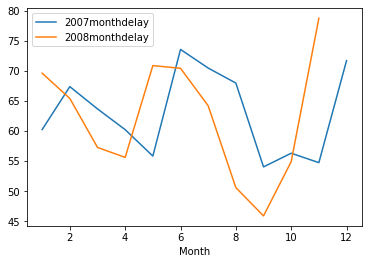

In [16]:
df_month_plot = df_2007_month[['Month','2007monthdelay']]
df_month_plot = df_2007_month.set_index('Month')
df_month_plot['2008monthdelay'] =  df_2008_month['2008monthdelay']

df_month_plot = df_month_plot[['2007monthdelay','2008monthdelay']]
df_month_plot.plot()



**Q3 Answer:** As we can see from the above plot:
In 2007: June and December have much higher average delay while September has the lowest average delay. 

In 2008, May, June November and December have much higher average delay while the September has the lowest average delay.  

Therefore, we can conclude that the average delay tends to reach higher in May and June, and went down to the lowest in Sepetemer, and then reach higher again in winter

**Q4**.Do you see any increase or decrease in delays on weekends?

In [17]:
#Filtering
df_2007_dep = df_2007.filter((df_2007['DepDelay'].isNotNull()) & (df_2007['DepDelay'] >0))
df_2008_dep = df_2008.filter((df_2008['DepDelay'].isNotNull()) & (df_2008['DepDelay'] >0))
df_2007_arr = df_2007.filter((df_2007['ArrDelay'].isNotNull()) & (df_2007['ArrDelay'] >0))
df_2008_arr = df_2008.filter((df_2008['ArrDelay'].isNotNull()) & (df_2008['ArrDelay'] >0))

df_2007_dep_DayOfWeek = df_2007_dep.groupby('DayOfWeek').agg(avg('DepDelay').alias('byDayOfWeekdelaydep')).orderBy('DayOfWeek',ascending = True).toPandas()
df_2007_arr_DayOfWeek = df_2007_arr.groupby('DayOfWeek').agg(avg('ArrDelay').alias('byDayOfWeekdelay')).orderBy('DayOfWeek',ascending = True).toPandas()
df_2008_dep_DayOfWeek = df_2008_dep.groupby('DayOfWeek').agg(avg('DepDelay').alias('byDayOfWeekdelaydep')).orderBy('DayOfWeek',ascending = True).toPandas()
df_2008_arr_DayOfWeek = df_2008_arr.groupby('DayOfWeek').agg(avg('ArrDelay').alias('byDayOfWeekdelay')).orderBy('DayOfWeek',ascending = True).toPandas()


df_2007_DayOfWeek = df_2007_dep_DayOfWeek.merge(df_2007_arr_DayOfWeek,on = 'DayOfWeek',how = 'inner')
df_2008_DayOfWeek = df_2008_dep_DayOfWeek.merge(df_2008_arr_DayOfWeek,on = 'DayOfWeek',how = 'inner')
df_2007_DayOfWeek['2007DayOfWeekdelay'] = df_2007_DayOfWeek.byDayOfWeekdelaydep + df_2007_DayOfWeek.byDayOfWeekdelay
df_2008_DayOfWeek['2008DayOfWeekdelay'] = df_2008_DayOfWeek.byDayOfWeekdelaydep + df_2008_DayOfWeek.byDayOfWeekdelay


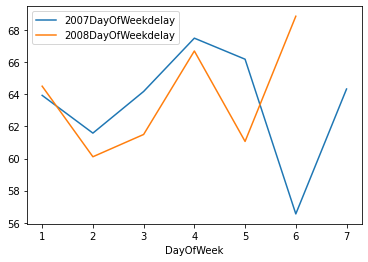

In [18]:
df_DayOfWeek_plot = df_2007_DayOfWeek[['DayOfWeek','2007DayOfWeekdelay']]
df_DayOfWeek_plot = df_2007_DayOfWeek.set_index('DayOfWeek')
df_DayOfWeek_plot['2008DayOfWeekdelay'] =  df_2008_DayOfWeek['2008DayOfWeekdelay']

df_DayOfWeek_plot = df_DayOfWeek_plot[['2007DayOfWeekdelay','2008DayOfWeekdelay']]
df_DayOfWeek_plot.plot()


**Q4 Answer**: As we can see from the above plot:
both of these two years have similar trends in different days of the week: the average delay is low in Tuesday, but climb higher on Thursday and the weekends as well

**Q5**.Are flights equally distributed throughout the day?
Plot the distribution of DepTime, ArrTime (actual departure and arrival time


In [19]:
!pip install pyspark-dist-explore
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, '2007 DepTime Frequency Plot')

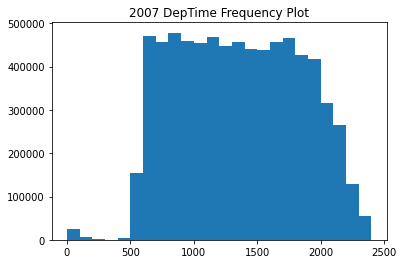

In [20]:
#Plot for 2007 Departure
df5 = df_2007.filter(df_2007['DepTime'].isNotNull()).select(df_2007['DepTime'])
df5 = df5.withColumn('DepTime',df5['DepTime'].cast(IntegerType()))

bins , avg = df5.rdd.flatMap(lambda x:x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=avg)
plt.title('2007 DepTime Frequency Plot')



Text(0.5, 1.0, '2008 ArrTime Frequency Plot')

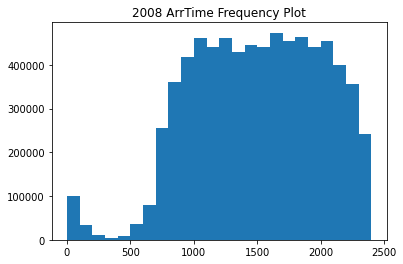

In [21]:
#Plot for 2007 Arrival Time
df51 = df_2007.filter(df_2007['ArrTime'].isNotNull()).select(df_2007['ArrTime'])
df51 = df51.withColumn('ArrTime',df51['ArrTime'].cast(IntegerType()))

bins , avg = df51.rdd.flatMap(lambda x:x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=avg)
plt.title('2008 ArrTime Frequency Plot')

Text(0.5, 1.0, '2008 DepTime Frequency Plot')

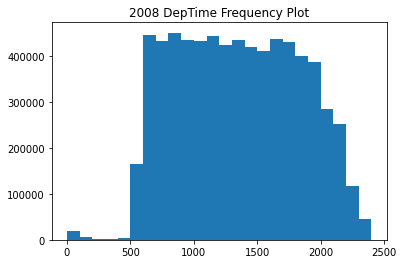

In [22]:
#Plot for 2008 Departure
df52 = df_2008.filter(df_2008['DepTime'].isNotNull()).select(df_2008['DepTime'])
df52 = df52.withColumn('DepTime',df52['DepTime'].cast(IntegerType()))

bins , avg = df52.rdd.flatMap(lambda x:x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=avg)
plt.title('2008 DepTime Frequency Plot')


Text(0.5, 1.0, '2008 ArrTime Frequency Plot')

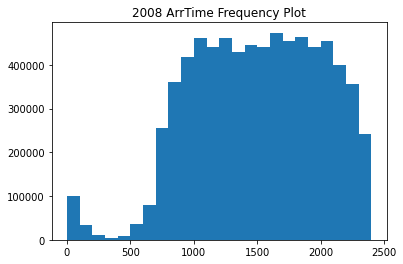

In [23]:
#Plot for 2007 Arrival Time
df53 = df_2007.filter(df_2007['ArrTime'].isNotNull()).select(df_2007['ArrTime'])
df53 = df53.withColumn('ArrTime',df53['ArrTime'].cast(IntegerType()))

bins , avg = df53.rdd.flatMap(lambda x:x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=avg)
plt.title('2008 ArrTime Frequency Plot')

**Q5 Answer:** As we can see from the four histogram plots above, it is not equally distributed throughout the day. Typically the airpot experience a relatively high delay value from 6am to 10pm, while the rest of the day normally has a quite low delay value in both 2007 and 2008


**Q6** Do you see the worst delays at any certain times of the day?
 Compare DepTime, ArrTime with CRSDepTime, CRSArrTime (scheduled arrival and departure time; CRS is the Computer Reservation System)

In [24]:
#Filtering
df_2007_dep_6 = df_2007_dep.filter(df_2007_dep['CRSDepTime'].isNotNull())
df_2007_arr_6 = df_2007_arr.filter(df_2007_arr['CRSDepTime'].isNotNull())
df_2008_dep_6 = df_2008_dep.filter(df_2008_dep['CRSDepTime'].isNotNull())
df_2008_arr_6 = df_2008_arr.filter(df_2008_arr['CRSDepTime'].isNotNull())



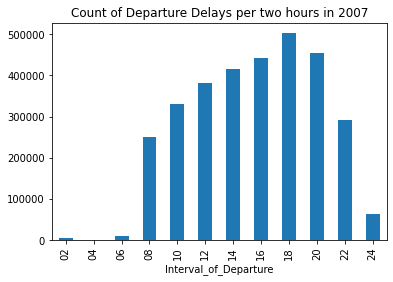

In [25]:
#2007 departure delay
df_2007_dep_6 = df_2007_dep_6.withColumn('Interval_of_Departure',
                                         when(col('CRSDepTime') < 200,'02').
                                         when(col('CRSDepTime') < 400,'04').\
                                         when(col('CRSDepTime') < 600,'06').\
                                         when(col('CRSDepTime') < 800,'08').\
                                         when(col('CRSDepTime') < 1000,'10').\
                                         when(col('CRSDepTime') < 1200,'12').\
                                         when(col('CRSDepTime') < 1400,'14').\
                                         when(col('CRSDepTime') < 1600,'16').\
                                         when(col('CRSDepTime') < 1800,'18').\
                                         when(col('CRSDepTime') < 2000,'20').\
                                         when(col('CRSDepTime') < 2200,'22').\
                                         when(col('CRSDepTime') < 2400,'24')).select('Interval_of_Departure')
             

df_2007_dep_6 = df_2007_dep_6.groupby('Interval_of_Departure').agg(count(df_2007_dep_6['Interval_of_Departure']).alias('delaycount'))
df_2007_dep_6 = df_2007_dep_6.orderBy('Interval_of_Departure',ascending = True)
df_2007_dep_6= df_2007_dep_6.toPandas()   
df_2007_dep_6.plot(kind='bar',x='Interval_of_Departure', y='delaycount', legend=None, title="Count of Departure Delays per two hours in 2007")



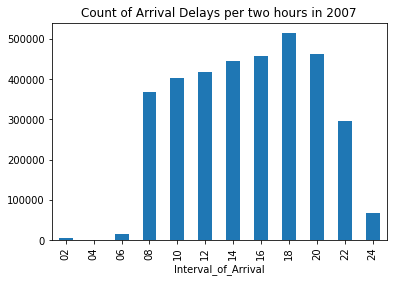

In [26]:
#2007 Arrival delay

df_2007_arr_6 = df_2007_arr_6.withColumn('Interval_of_Arrival',
                                         when(col('CRSDepTime') < 200,'02').
                                         when(col('CRSDepTime') < 400,'04').\
                                         when(col('CRSDepTime') < 600,'06').\
                                         when(col('CRSDepTime') < 800,'08').\
                                         when(col('CRSDepTime') < 1000,'10').\
                                         when(col('CRSDepTime') < 1200,'12').\
                                         when(col('CRSDepTime') < 1400,'14').\
                                         when(col('CRSDepTime') < 1600,'16').\
                                         when(col('CRSDepTime') < 1800,'18').\
                                         when(col('CRSDepTime') < 2000,'20').\
                                         when(col('CRSDepTime') < 2200,'22').\
                                         when(col('CRSDepTime') < 2400,'24')).select('Interval_of_Arrival')
df_2007_arr_6 = df_2007_arr_6.groupby('Interval_of_Arrival').agg(count(df_2007_arr_6['Interval_of_Arrival']).alias('delaycount'))
df_2007_arr_6 = df_2007_arr_6.orderBy('Interval_of_Arrival',ascending = True)
df_2007_arr_6= df_2007_arr_6.toPandas()   
df_2007_arr_6.plot(kind='bar',x='Interval_of_Arrival', y='delaycount', legend=None, title="Count of Arrival Delays per two hours in 2007")           


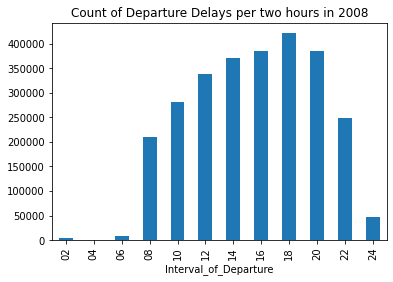

In [27]:
#2008 departure delay
df_2008_dep_6 = df_2008_dep_6.withColumn('Interval_of_Departure',
                                         when(col('CRSDepTime') < 200,'02').
                                         when(col('CRSDepTime') < 400,'04').\
                                         when(col('CRSDepTime') < 600,'06').\
                                         when(col('CRSDepTime') < 800,'08').\
                                         when(col('CRSDepTime') < 1000,'10').\
                                         when(col('CRSDepTime') < 1200,'12').\
                                         when(col('CRSDepTime') < 1400,'14').\
                                         when(col('CRSDepTime') < 1600,'16').\
                                         when(col('CRSDepTime') < 1800,'18').\
                                         when(col('CRSDepTime') < 2000,'20').\
                                         when(col('CRSDepTime') < 2200,'22').\
                                         when(col('CRSDepTime') < 2400,'24')).select('Interval_of_Departure')
             

df_2008_dep_6 = df_2008_dep_6.groupby('Interval_of_Departure').agg(count(df_2008_dep_6['Interval_of_Departure']).alias('delaycount'))
df_2008_dep_6 = df_2008_dep_6.orderBy('Interval_of_Departure',ascending = True)
df_2008_dep_6= df_2008_dep_6.toPandas()   
df_2008_dep_6.plot(kind='bar',x='Interval_of_Departure', y='delaycount', legend=None, title="Count of Departure Delays per two hours in 2008")



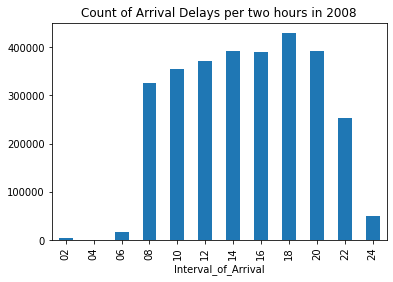

In [28]:
#2008 Arrival delay

df_2008_arr_6 = df_2008_arr_6.withColumn('Interval_of_Arrival',
                                         when(col('CRSDepTime') < 200,'02').
                                         when(col('CRSDepTime') < 400,'04').\
                                         when(col('CRSDepTime') < 600,'06').\
                                         when(col('CRSDepTime') < 800,'08').\
                                         when(col('CRSDepTime') < 1000,'10').\
                                         when(col('CRSDepTime') < 1200,'12').\
                                         when(col('CRSDepTime') < 1400,'14').\
                                         when(col('CRSDepTime') < 1600,'16').\
                                         when(col('CRSDepTime') < 1800,'18').\
                                         when(col('CRSDepTime') < 2000,'20').\
                                         when(col('CRSDepTime') < 2200,'22').\
                                         when(col('CRSDepTime') < 2400,'24')).select('Interval_of_Arrival')
df_2008_arr_6 = df_2008_arr_6.groupby('Interval_of_Arrival').agg(count(df_2008_arr_6['Interval_of_Arrival']).alias('delaycount'))
df_2008_arr_6 = df_2008_arr_6.orderBy('Interval_of_Arrival',ascending = True)
df_2008_arr_6= df_2008_arr_6.toPandas()   
df_2008_arr_6.plot(kind='bar',x='Interval_of_Arrival', y='delaycount', legend=None, title="Count of Arrival Delays per two hours in 2008")           


**Q6 Answer:** As we can see from the plots above, the time 16-18 in the afternoon is the time period that has the worst arrival delay and departure delay for both years